In [2]:
pip install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
args = {}
args["dataset"] = r"D:\SDP\custom\dataset"  # replace with your actual dataset path

In [6]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

IMG_SIZE = 96
CHANNELS = 3
N_LABELS=2


# loop over the image paths
from PIL import Image
for imagePath in imagePaths:
	# extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
  image = Image.open(imagePath)
  if image.mode == 'P':
    image = image.convert('RGBA') 
	# load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(IMG_SIZE, IMG_SIZE))
  image = img_to_array(image)
  image = image/255
#image = preprocess_input(image)

	# update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


C:\Users\utkar\anaconda3\envs\incepv3\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

In [9]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
    vertical_flip=True,
	fill_mode="nearest")


In [10]:
input_shape = (96,96,3)

In [11]:
# Build Model
input_image = Input(shape=input_shape)
# 1st Conv layer
model = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_image)
model = MaxPooling2D((2, 2),padding='same')(model)
# 2nd Conv layer
model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 3rd Conv layer
model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 4th Conv layer
model = Conv2D(128, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 5th Conv layer
model = Conv2D(256, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# FC layers
model = Flatten()(model)
#model = Dense(1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
model = Dense(1024)(model)
#model = Dropout(0.2)(model)

#model = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
model = Dense(64)(model)
#model = Dropout(0.2)(model)

output= Dense(2, activation='softmax')(model)

model = Model(inputs=[input_image], outputs=[output])

In [12]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0     

In [14]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 100
BS = 32

In [16]:
optimizer=Adam(learning_rate=LR,decay=LR/EPOCHS)
model.compile(
  #optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  
  loss="binary_crossentropy",
  metrics=["accuracy"])


In [17]:
import time
start = time.time()
history = model.fit(aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
    validation_steps=len(testX)//BS,
	epochs=EPOCHS)
print('\nTraining took {}'.format((time.time()-start)))

Epoch 1/100
102/102 [==============================] - 24s 221ms/step - loss: 0.7317 - accuracy: 0.6226 - val_loss: 0.6149 - val_accuracy: 0.7717
Epoch 2/100
102/102 [==============================] - 22s 214ms/step - loss: 0.5177 - accuracy: 0.7815 - val_loss: 0.3750 - val_accuracy: 0.8230
Epoch 3/100
102/102 [==============================] - 22s 218ms/step - loss: 0.3891 - accuracy: 0.8396 - val_loss: 0.2216 - val_accuracy: 0.9206
Epoch 4/100
102/102 [==============================] - 22s 219ms/step - loss: 0.3346 - accuracy: 0.8683 - val_loss: 0.3553 - val_accuracy: 0.8388
Epoch 5/100
102/102 [==============================] - 22s 218ms/step - loss: 0.3165 - accuracy: 0.8726 - val_loss: 0.1802 - val_accuracy: 0.9377
Epoch 6/100
102/102 [==============================] - 23s 221ms/step - loss: 0.2827 - accuracy: 0.8858 - val_loss: 0.1746 - val_accuracy: 0.9341
Epoch 7/100
102/102 [==============================] - 23s 221ms/step - loss: 0.2711 - accuracy: 0.8902 - val_loss: 0.1964 -

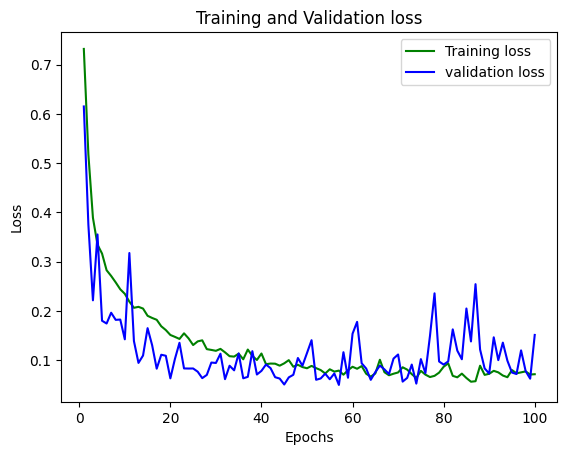

In [22]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(r"D:\SDP\custom\T&V_loss_custom.png")
plt.show()

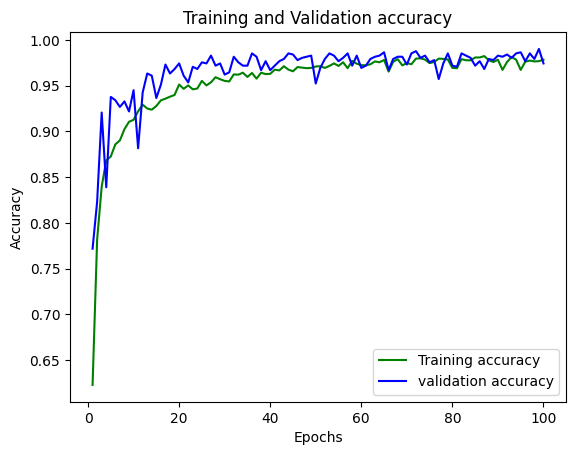

In [23]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"D:\SDP\custom\T&V_acc_custom.png")
plt.show()

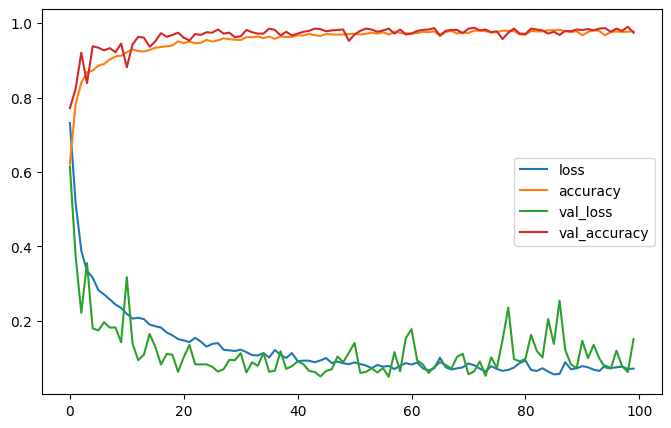

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.savefig(r"D:\SDP\custom\plot.png")
plt.show()

In [21]:
predict=model.predict(testX,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(testY.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.96      0.98       433
without_mask       0.96      0.99      0.97       386

    accuracy                           0.97       819
   macro avg       0.97      0.98      0.97       819
weighted avg       0.97      0.97      0.97       819



In [25]:
model.save('custom19_06.h5')